# Import Libraries

In [4]:
import warnings
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from datasets import load_dataset
import torch
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
# Filter out all warnings
warnings.filterwarnings("ignore")


- This section loads necessary libraries and sets the computation device to GPU if available.

In [ ]:
# Ensure CUDA (GPU support) is available if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Task 1. Alpaca Dataset 

## Load Dataset

Loading the training and evaluation datasets, with 
 - the training dataset limited to the first 100 examples and 
 - the evaluation dataset to the first 25 examples.

In [7]:
# Load the datasets
train_ds = load_dataset('json', data_files='./data/alpaca_data.json', split='train').select(range(100))
eval_ds = load_dataset("tatsu-lab/alpaca_eval", split='eval', trust_remote_code=True).select(range(25))


In [8]:
train_ds

Dataset({
    features: ['input', 'instruction', 'output'],
    num_rows: 100
})

In [9]:
eval_ds

Dataset({
    features: ['instruction', 'output', 'generator', 'dataset'],
    num_rows: 25
})

In [10]:
eval_ds = eval_ds.remove_columns(['generator','dataset']) #deleting unncessary columns

In [11]:
eval_ds

Dataset({
    features: ['instruction', 'output'],
    num_rows: 25
})

## Tokenization

- Here, the script loads the DistilGPT-2 model and tokenizer. 
- It sets the padding token to the end-of-sequence token and defines the maximum sequence length based on the model's limitations.

In [12]:
# Step 2: Load the model & Tokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "distilgpt2"
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    device_map = 'auto'
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
# Make sure to pass a correct value for max_seq_length as the default value will be set to min(tokenizer.model_max_length, 1024).
max_seq_length = min(tokenizer.model_max_length, 1024)
max_seq_length

1024

## Data Formatting

- This function is designed to format the dataset examples into a specific prompt format required for training the model. 
- The format includes a question, optional input, and the answer section.

In [14]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        input_text = example["input"][i] if 'input' in example.keys() else ""
        if len(input_text) :
            text = f"### Question: {example['instruction'][i]}\n### Input: {example['input'][i]}\n### Answer: {example['output'][i]}"
        else:
            text = f"### Question: {example['instruction'][i]}\n### Answer: {example['output'][i]}"
        output_texts.append(text)
    return output_texts

formatted_examples = formatting_prompts_func(train_ds[:10])
for example in formatted_examples:
    print(example)
    
formatted_examples = formatting_prompts_func(eval_ds[:5])
for example in formatted_examples:
    print(example)

### Question: Give three tips for staying healthy.
### Answer: 1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.
### Question: What are the three primary colors?
### Answer: The three primary colors are red, blue, and yellow.
### Question: Describe the structure of an atom.
### Answer: An atom is made up of a nucleus, which contains protons and neutrons, surrounded by electrons that travel in orbits around the nucleus. The protons and neutrons have a positive charge, while the electrons have a negative charge, resulting in an overall neutral atom. The number of each particle determines the atomic number and the type of atom.
### Question: How can we reduce air pollution?
### Answer: There are a number of ways to reduce air pollution, such as shifting to renewable energy sources, encouraging the use of public transportation, prohibiting

## Data Collator Configuration

- Configures a data collator for the model training, specifically for completion-only language modeling, setting up a template for how responses should be formatted in the training data.

In [15]:
# use the DataCollatorForCompletionOnlyLM to train  model on the generated prompts only
response_template = '### Answer:'
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)
collator

DataCollatorForCompletionOnlyLM(tokenizer=GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}, mlm=False, mlm_probability=0.15, pad_to_multiple_of=None, tf_experimental_compile=False, return_tensors='pt')

In [16]:
eval_ds

Dataset({
    features: ['instruction', 'output'],
    num_rows: 25
})

# Task 2. Model Training

## Training Configuration

- Defines training arguments and initializes a trainer object with the model, tokenizer, training arguments, and datasets, preparing the model for training.

In [40]:
# Adjust TrainingArguments to include evaluation settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,  # Only keep one checkpoint
)

# Initialize the trainer
trainer = SFTTrainer(
    model,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    data_collator=collator,
    args=training_args,
    formatting_func=formatting_prompts_func,
)

Map: 100%|██████████| 25/25 [00:00<00:00, 2201.87 examples/s]


# Task 3. Model Evaluation 

## Training and Evaluation

- Executes training and evaluation for a specified number of epochs, collecting training and evaluation losses for analysis.

In [19]:
# Train the model and save the loss values
train_loss_values = []
eval_loss_values = []
for epoch in range(training_args.num_train_epochs):
    # Train one epoch
    trainer.train()
    
    # Evaluate
    eval_output = trainer.evaluate()
    
    # Save train and eval losses
    train_loss_values.extend([log.get('train_loss') for log in trainer.state.log_history])
    eval_loss_values.append(eval_output['eval_loss'])

 13%|█▎        | 10/75 [00:54<04:59,  4.61s/it]

{'loss': 2.9466, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}


 27%|██▋       | 20/75 [01:46<04:55,  5.37s/it]

{'loss': 2.5865, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


                                               
 33%|███▎      | 25/75 [02:28<04:27,  5.35s/it]

{'eval_loss': 2.4634296894073486, 'eval_runtime': 12.9353, 'eval_samples_per_second': 1.933, 'eval_steps_per_second': 0.541, 'epoch': 1.0}


 40%|████      | 30/75 [02:53<04:17,  5.71s/it]

{'loss': 2.5982, 'learning_rate': 3e-05, 'epoch': 1.2}


 53%|█████▎    | 40/75 [03:42<02:47,  4.80s/it]

{'loss': 2.5137, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


 67%|██████▋   | 50/75 [04:35<01:55,  4.62s/it]

{'loss': 2.3363, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                               
 67%|██████▋   | 50/75 [04:48<01:55,  4.62s/it]

{'eval_loss': 2.4569404125213623, 'eval_runtime': 12.1468, 'eval_samples_per_second': 2.058, 'eval_steps_per_second': 0.576, 'epoch': 2.0}


 80%|████████  | 60/75 [05:43<01:27,  5.84s/it]

{'loss': 2.2989, 'learning_rate': 1e-05, 'epoch': 2.4}


 93%|█████████▎| 70/75 [06:28<00:22,  4.41s/it]

{'loss': 2.3268, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}


                                               
100%|██████████| 75/75 [07:09<00:00,  5.72s/it]


{'eval_loss': 2.463404417037964, 'eval_runtime': 11.9394, 'eval_samples_per_second': 2.094, 'eval_steps_per_second': 0.586, 'epoch': 3.0}
{'train_runtime': 429.347, 'train_samples_per_second': 0.699, 'train_steps_per_second': 0.175, 'train_loss': 2.4947877248128254, 'epoch': 3.0}


 13%|█▎        | 10/75 [00:39<04:22,  4.04s/it]

{'loss': 2.1474, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}


 27%|██▋       | 20/75 [01:33<04:56,  5.39s/it]

{'loss': 2.2468, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


 33%|███▎      | 25/75 [02:11<03:57,  4.74s/it]

{'eval_loss': 2.5071544647216797, 'eval_runtime': 11.7924, 'eval_samples_per_second': 2.12, 'eval_steps_per_second': 0.594, 'epoch': 1.0}


 40%|████      | 30/75 [02:37<04:33,  6.08s/it]

{'loss': 1.9034, 'learning_rate': 3e-05, 'epoch': 1.2}


 53%|█████▎    | 40/75 [03:15<02:10,  3.74s/it]

{'loss': 2.033, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


 67%|██████▋   | 50/75 [04:08<01:48,  4.34s/it]

{'loss': 1.9018, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 50/75 [04:20<01:48,  4.34s/it]

{'eval_loss': 2.561584234237671, 'eval_runtime': 11.9079, 'eval_samples_per_second': 2.099, 'eval_steps_per_second': 0.588, 'epoch': 2.0}


 80%|████████  | 60/75 [05:12<01:23,  5.57s/it]

{'loss': 1.938, 'learning_rate': 1e-05, 'epoch': 2.4}


 93%|█████████▎| 70/75 [05:56<00:22,  4.44s/it]

{'loss': 1.7739, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}


100%|██████████| 75/75 [06:33<00:00,  5.24s/it]


{'eval_loss': 2.5829665660858154, 'eval_runtime': 12.0414, 'eval_samples_per_second': 2.076, 'eval_steps_per_second': 0.581, 'epoch': 3.0}
{'train_runtime': 393.0662, 'train_samples_per_second': 0.763, 'train_steps_per_second': 0.191, 'train_loss': 1.9716752243041993, 'epoch': 3.0}


 13%|█▎        | 10/75 [00:40<05:02,  4.65s/it]

{'loss': 1.6366, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}


 27%|██▋       | 20/75 [01:37<05:48,  6.34s/it]

{'loss': 1.6572, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


 33%|███▎      | 25/75 [02:13<04:03,  4.86s/it]

{'eval_loss': 2.6444549560546875, 'eval_runtime': 11.9195, 'eval_samples_per_second': 2.097, 'eval_steps_per_second': 0.587, 'epoch': 1.0}


 40%|████      | 30/75 [02:37<04:28,  5.96s/it]

{'loss': 1.5978, 'learning_rate': 3e-05, 'epoch': 1.2}


 53%|█████▎    | 40/75 [03:24<02:20,  4.02s/it]

{'loss': 1.5236, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


 67%|██████▋   | 50/75 [04:12<01:54,  4.59s/it]

{'loss': 1.4916, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                               
 67%|██████▋   | 50/75 [04:24<01:54,  4.59s/it]

{'eval_loss': 2.762598991394043, 'eval_runtime': 11.9736, 'eval_samples_per_second': 2.088, 'eval_steps_per_second': 0.585, 'epoch': 2.0}


 80%|████████  | 60/75 [05:16<01:17,  5.20s/it]

{'loss': 1.4911, 'learning_rate': 1e-05, 'epoch': 2.4}


 93%|█████████▎| 70/75 [06:01<00:25,  5.01s/it]

{'loss': 1.4912, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}


100%|██████████| 75/75 [06:41<00:00,  5.36s/it]


{'eval_loss': 2.7701473236083984, 'eval_runtime': 11.7829, 'eval_samples_per_second': 2.122, 'eval_steps_per_second': 0.594, 'epoch': 3.0}
{'train_runtime': 401.9477, 'train_samples_per_second': 0.746, 'train_steps_per_second': 0.187, 'train_loss': 1.5435860443115235, 'epoch': 3.0}


100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


## Loss Plotting

- This section includes code for plotting the training and evaluation loss over epochs, providing a visual analysis of the model's learning progress.

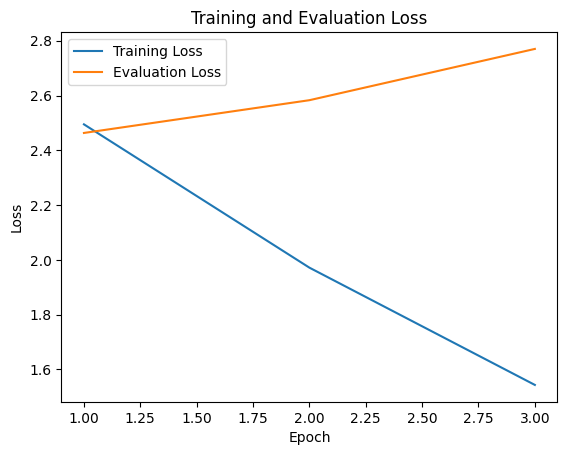

In [30]:
# Filter out None values from train_loss_values and eval_loss_values
train_loss_values = [loss for loss in train_loss_values if loss is not None]
eval_loss_values = [loss for loss in eval_loss_values if loss is not None]

# Check if train_loss_values and eval_loss_values are not empty
if train_loss_values and eval_loss_values:
    # Plot training and evaluation loss
    plt.plot(np.arange(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss')
    plt.plot(np.arange(1, len(eval_loss_values) + 1), eval_loss_values, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()
else:
    print("No valid loss values to plot.")


In [44]:
# Filter out None values from train_loss_values and eval_loss_values
train_loss_values , eval_loss_values

([2.4947877248128254, 1.9716752243041993, 1.5435860443115235],
 [2.463404417037964, 2.5829665660858154, 2.7701473236083984])

**Training Loss per Epoch:**
- Epoch 1: 2.4948
- Epoch 2: 1.9717
- Epoch 3: 1.5436

**Validation Loss per Epoch:**
- Epoch 1: 2.4634
- Epoch 2: 2.5829
- Epoch 3: 2.7701

**Analysis:**
- The **training loss** shows a **consistent decrease**, indicating effective learning and optimization by the model.
- The **validation loss** initially drops but then **increases**, suggesting the model might be **overfitting**. While the model is improving on the training data, its performance on unseen data (validation) worsens.

**Conclusion:**
- The training trends are positive, but the rise in validation loss points to a need for strategies to improve generalization, such as **early stopping**, **regularization**, or **model adjustments** to prevent overfitting.


## Performance Evaluation

- Evaluates the performance of the model by generating responses for the evaluation dataset and calculating the BLEU score for each response against the gold label, averaging the scores to assess the overall performance.

In [31]:

# Initialize lists to store generated responses and gold labels
generated_responses = []
gold_labels = []

# Generate responses for each example in the eval dataset
for example in eval_ds:
    # Generate response using the trained model
    input_prompt = example['instruction']
    input_ids = tokenizer(input_prompt, return_tensors='pt')['input_ids'].to(device)
    generated_output = model.generate(input_ids, max_length=100, num_return_sequences=1)
    generated_response = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    generated_responses.append(generated_response)
    
    # Get gold label
    gold_label = example['output']
    gold_labels.append(gold_label)



bleu_scores = []
for generated_response, gold_label in zip(generated_responses, gold_labels):
    bleu_score = sentence_bleu([gold_label.split()], generated_response.split())
    bleu_scores.append(bleu_score)

# Compute average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)


Average BLEU Score: 0.006136807820852075


**Average BLEU Score on `eval_ds`:**
- **Score**: 0.0061

**Interpretation:**
- The **BLEU score** quantifies the similarity between the machine-generated text and reference (human) text, with a range from 0 to 1. Higher scores indicate better alignment with the reference text.
- An **average BLEU score of 0.0061** is quite low, suggesting that the generated text significantly differs from the expected human-written reference texts in the evaluation dataset (`eval_ds`).

**Implications:**
- This low score could indicate **challenges** the model faces in capturing the nuances of the language or the specifics of the task.
- It highlights the need for further **model refinement** or **training data adjustment** to improve performance.

**Next Steps:**
- Investigating the **model's learning process**, increasing **data quantity and quality**, and Investigating the **evaluation setup** could provide insights into improving this score.
- Exploring **alternative models**, **hyperparameter tuning**, or **data augmentation** strategies might also enhance the model's ability to generate more accurate and human-like text.


## Save and Load Model

- Saves the trained model and tokenizer to disk and demonstrates how to load them back into the script, preparing them for inference.

In [41]:
# Save the model and tokenizer
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/merges.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

In [33]:
# Load the trained model and tokenizer
model_path = './trained_model'  # Adjust if your model is saved elsewhere
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id
# Ensure the model is in evaluation mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Inference and Response Generation

- Defines a function for generating responses using the trained model and demonstrates its usage with an example question and context. It showcases how the model can be applied to generate answers to new queries.

In [37]:
def generate_response(question, context=None):
    """
    Generate an answer based on a given question and optional context.

    Parameters:
    - question (str): The question or instruction.
    - context (str, optional): Additional context to provide background for the answer.

    Returns:
    - str: The generated answer.
    """
    # Adjust the prompt format to match the training format
    formatted_prompt = f"### Question: {question}\n### Answer:"
    if context:
        formatted_prompt = f"{context}\n{formatted_prompt}"

    # Encode the prompt to tensor
    input_ids = tokenizer.encode(formatted_prompt, return_tensors='pt').to(device)

    # Generate an answer
    with torch.no_grad():  # No need to track gradients
        output_ids = model.generate(input_ids, max_length=200, num_return_sequences=1, temperature=0.1, top_p=0.9)

    # Decode and return the generated text
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # Extracting the generated answer (post-processing might be needed depending on the model's output)
    answer_start = generated_text.find("### Answer:") + len("### Answer:")
    generated_answer = generated_text[answer_start:].strip()

    return generated_answer


In [42]:
# Example usage
question = "What is a polite way to respond to a customer asking for a refund?"
context = "The customer purchased a vacuum cleaner that stopped working after one week."  # Can be None if not applicable
answer = generate_response(question, context)
print("Question :\n",question)
print("Context \n",context)
print("Generated Answer:\n", answer)

Question :
 What is a polite way to respond to a customer asking for a refund?
Context 
 The customer purchased a vacuum cleaner that stopped working after one week.
Generated Answer:
 A polite way to respond to a customer asking for a refund is by contacting the customer service line at 1-800-8255. The customer will be directed to the customer service line at 1-800-8255. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the cus

In [39]:
import random

# Select a random example from eval_ds
random_example = random.choice(eval_ds)

# Get the instruction from the random example
instruction = random_example['instruction']

# Generate a response using the trained model
generated_response = generate_response(instruction)

# Print the instruction, gold label, and generated response
print("Instruction:\n", instruction)
print("Gold Label:\n", random_example['output'])
print("Generated Response:\n", generated_response)


Instruction:
 How do you become an author?
Gold Label:
 1. Develop your writing skills. Read books, take writing classes, and practice your skills regularly.
2. Generate ideas for stories, poems, or other works. Think about topics you are passionate about and consider how to use them in your writing.
3. Outline your story or work, then begin writing. Use the outline as a guide and flesh out the details as you go.
4. Edit your work. Read through your work and make corrections and edits to improve it.
5. Seek feedback from others. Ask family, friends, or writing peers to review your work and provide feedback.
6. Publish your work. Consider submitting your work to literary agents or publishers, or self-publish your work online.
Generated Response:
 I am an avid reader of science fiction and fantasy. I have read a lot of books, read a lot of books, and read books all over the world. I also like to read books that are both science fiction and fantasy. I also like to read books that are both

Question :
 What is a polite way to respond to a customer asking for a refund?
Context 
 The customer purchased a vacuum cleaner that stopped working after one week.
Generated Answer:
 A polite way to respond to a customer asking for a refund is by contacting the customer service line at 1-800-8255. The customer will be directed to the customer service line at 1-800-8255. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the customer. The customer will also be asked to provide a written response to the cus